In [29]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import multivariate_normal
from scipy import misc
import warnings
warnings.filterwarnings('ignore')

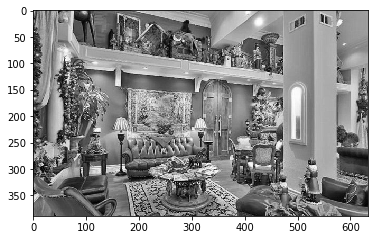

In [2]:
# Image
imagePath = 'details.jpg'
image = Image.open(imagePath)
grayscaleImage = image.convert('F')
plt.imshow(grayscaleImage, cmap='gray')
plt.show()

In [3]:
# Variables
sigma = 1.6
s = 2
k = 2 ** (1/s)
noOfOctaves = 4
imagesPerOctave = s + 3

In [4]:
# Initialize arrays of values which will be used as a blur parameter to the gaussian filter
blurValues = np.zeros((noOfOctaves, imagesPerOctave))
val = sigma/2
for i in range(noOfOctaves):
    for j in range(imagesPerOctave):
        blurValues[i][j] = val
        val = val*k
    val = blurValues[i][2]
blurValues

array([[ 0.8       ,  1.13137085,  1.6       ,  2.2627417 ,  3.2       ],
       [ 1.6       ,  2.2627417 ,  3.2       ,  4.5254834 ,  6.4       ],
       [ 3.2       ,  4.5254834 ,  6.4       ,  9.0509668 , 12.8       ],
       [ 6.4       ,  9.0509668 , 12.8       , 18.1019336 , 25.6       ]])

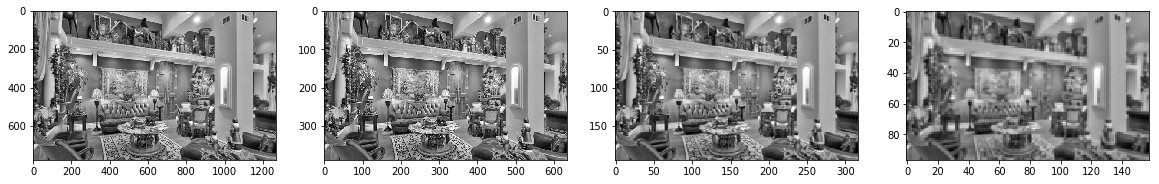

In [5]:
# Set up images of different scales for each octave
Images = []
ImageSize2 = np.array(grayscaleImage) # original-size image
ImageSize1 = misc.imresize(ImageSize2, 200, 'bilinear')
ImageSize4 = misc.imresize(ImageSize2, 50, 'bilinear')
ImageSize8 = misc.imresize(ImageSize4, 50, 'bilinear')
Images.append(ImageSize1)
Images.append(ImageSize2)
Images.append(ImageSize4)
Images.append(ImageSize8)

fig = plt.figure(figsize=(20, 20))
for i in range(len(Images)):
    fig.add_subplot(1, 4, i+1)
    plt.imshow(Images[i], cmap='gray')
plt.show()

In [6]:
# Calculate Gaussian blurred images for each octave
octaves = []
for i in range(noOfOctaves):
    octaves.append(np.zeros((Images[i].shape[0], Images[i].shape[1], imagesPerOctave)))

for i in range(noOfOctaves):
    for j in range(imagesPerOctave):
        octaves[i][:,:,j]= gaussian_filter(Images[i], sigma=blurValues[i][j])

In [7]:
# Calculate differences of Gaussians(DoG) for each octave
DoGs = []
DoGImageNo = imagesPerOctave-1

for i in range(DoGImageNo):
    DoGs.append(np.zeros((Images[i].shape[0], Images[i].shape[1], DoGImageNo)))

for i in range(noOfOctaves):
    for j in range(DoGImageNo):
        DoGs[i][:,:,j] = octaves[i][:,:,j+1] - octaves[i][:,:,j]

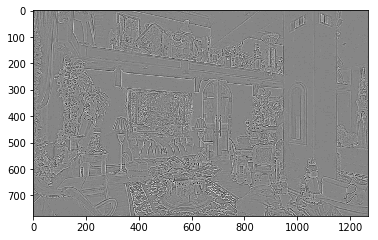

In [8]:
plt.imshow(DoGs[0][:,:,0], cmap='gray')
plt.show()

In [52]:
# Locate extrema in DoG images
# Filter the extrema, removing keypoints along edges
contrastThreshold = 0.03
keypoints = []
eigenValMagRatio = 10

for octave in range(noOfOctaves):
    for i in range(1, DoGImageNo - 1):
        for y in range(1, DoGs[octave][:,:,i].shape[0] - 1):
            for x in range(1, DoGs[octave][:,:,i].shape[1] - 1):
                currPixVal = DoGs[octave][y, x, i]
                if np.abs(currPixVal / 255)  < contrastThreshold:
                    continue
                isMin = True
                isMax = True
                for r in range(-1, 2):
                    for q in range(-1, 2):
                        for p in range(-1, 2):
                            if p==0 and q==0 and r==0:
                                continue
                            neighbour = DoGs[octave][y+q, x+p, i+r]
                            if neighbour <= currPixVal:
                                isMin = False
                            if neighbour >= currPixVal:
                                isMax = False
                            if not isMax and not isMin:
                                break
                        if not isMax and not isMin:
                            break
                    if not isMax and not isMin:
                        break
                if isMax or isMin:
                    Dxx = DoGs[octave][y, x+1, i] - 2*DoGs[octave][y, x, i] + DoGs[octave][y, x-1, i]
                    Dyy = DoGs[octave][y+1, x, i] - 2*DoGs[octave][y, x, i] + DoGs[octave][y-1, x, i]
                    Dxy = (DoGs[octave][y+1, x+1, i] - DoGs[octave][y-1, x+1, i] - DoGs[octave][y+1, x-1, i] + DoGs[octave][y-1, x-1, i]) / 4
                    trace = Dxx + Dyy
                    det = Dxx*Dyy - Dxy**2
                    isKeyPoint = (trace**2 / det) / 255 < ((r + 1)**2 / r)

                    if isKeyPoint:
                        # (coords, octave, image in octave, blur, orientation, DoG pixel value)
                        keypoint = [(x,y), octave, i, blurValues[octave][i], 0, currPixVal]
                        keypoints.append(keypoint)


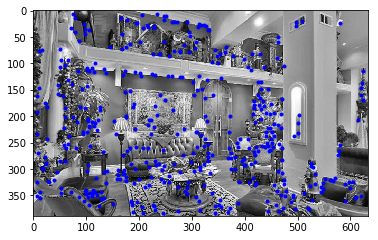

(2135, 436, 29, 6)

In [53]:
# Test area
bl0 = [j for j in keypoints if j[1] == 0]
bl1 = [j for j in keypoints if j[1] == 1]
bl2 = [j for j in keypoints if j[1] == 2]
bl3 = [j for j in keypoints if j[1] == 3]


plt.imshow(ImageSize2, cmap='gray')
x = [i[0][0] for i in bl1]
y = [i[0][1] for i in bl1]
plt.plot(x, y, 'bo', markersize=3)
plt.show()
len(bl0), len(bl1), len(bl2), len(bl3)

In [74]:
# keypoint magnitude and orientation assignment
# Find the DoG which has the nearest blur value compared to that of the current keypoint

magnitudes = []
for i in range(noOfOctaves):
    magnitudes.append(np.zeros((Images[i].shape[0], Images[i].shape[1], imagesPerOctave)))

orientations = []
for i in range(noOfOctaves):
    orientations.append(np.zeros((Images[i].shape[0], Images[i].shape[1], imagesPerOctave)))

# Orientations and magnitudes for each point in the images
for i in range(noOfOctaves):
    for j in range(imagesPerOctave):
        for y in range(1, octaves[i][:,:,j].shape[0] - 1):
            for x in range(1, octaves[i][:,:,j].shape[1] - 1):
                mag = np.sqrt(octaves[i][y, x+1, j] - octaves[i][y, x-1, j])**2 + (octaves[i][y+1, x, j] - octaves[i][y-1, x, j])**2
                ori = np.arctan2(octaves[i][y+1, x, j] - octaves[i][y-1, x, j], octaves[i][y, x+1, j] - octaves[i][y, x-1, j])
                ori = ori if ori>=0 else ori+2*np.pi
                magnitudes[i][y, x, j] = mag
                orientations[i][y, x, j] = ori

# Form an orientation histogram for each keypoint, using the neighbouring sample points
radPerBin = 2*np.pi / 36
for keypoint in keypoints:
    for j in range(-4, 5):
        for i in range(-4, 5):
            kpX = keypoint[0][0]
            kpY = keypoint[0][1]
            kpOct = keypoint[1]
            kpImgNo = keypoint[2]
            if kpX+i < 0 or kpX+i > octaves[kpOct][:,:,kpImgNo].shape[1]-1:
                continue
            if kpY+j < 0 or kpY+j > octaves[kpOct][:,:,kpImgNo].shape[0]-1:
                continue
            kpBlur = keypoint[3]
            kpHist = np.zeros(36)
            gaussBlurWin= multivariate_normal(mean=[i, j], cov=(1.5 * kpBlur))
            kpHistIdx = int(orientations[kpOct][kpY+j, kpX+i, kpImgNo] // radPerBin)
            kpHist[kpHistIdx] += octaves[kpOct][kpY+j, kpX+i, kpImgNo] * magnitudes[kpOct][kpY+j, kpX+i, kpImgNo] * gaussBlurWin.pdf([kpX+i,kpY+j])
            keypoint[4] = np.amax(kpHist)
            
            # Create a new keypoint for each histogram value that is within 80% of the highest peak
            kpHistMax = keypoint[4]
            kpHistMaxIdx = np.argmax(kpHist)
            for idx, elem in enumerate(kpHist):
                if elem > 0.8*kpHistMax and idx != kpHistMaxIdx:
                    keypoints.append((kpX, kpY), kpOct, kpImgNo, kpBlur, elem, keypoint[5])

In [75]:
# Keypoint descriptor calculation